In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

sns.set(rc={'figure.figsize': [18, 7]})

1. fz_44 - Contracts 44 federal law (small dataset)
2. fz_44_2 - Contracts 44 federal law (large dataset)
3. spravochnik - Directory of industrial production (small dataset)
4. prices - Price offers of suppliers (small dataset)
5. country - country name + ISO country code

In [ ]:
fz_44 = pd.read_csv('/content/drive/MyDrive/Zakupki/Контракты 44ФЗ.csv', sep=';', encoding='UTF-8')
spravochnik = pd.read_csv('/content/drive/MyDrive/Zakupki/Справочник пром производства.csv', sep=';', encoding='UTF-8')
prices = pd.read_csv('/content/drive/MyDrive/Zakupki/Ценовые предложения поставщиков.csv', sep=';', encoding='UTF-8')

fz_44_2 = pd.read_csv('/content/drive/MyDrive/Zakupki/Контракты 44ФЗ 2.csv', sep=';', encoding='UTF-8')

country = pd.read_csv('/content/drive/MyDrive/Zakupki/country_directory.csv', sep=';', encoding='UTF-8')

Preparing a dataframe for drawing a barplot with the distribution of units of measure for goods

In [ ]:
part1 = fz_44.groupby('okpd2_name').agg({'price': 'median'}).reset_index().rename(columns={'price': 'price_median'})
part2 = fz_44.groupby('okpd2_name').agg({'price': 'mean'}).reset_index().rename(columns={'price': 'price_mean'})
prices_name = part1.merge(part2, how='outer')

In [ ]:
msr_to_plot = pd.DataFrame(fz_44.product_msr.value_counts()).reset_index()
msr_to_plot.rename({'index': 'msr', 'product_msr': 'count'}, axis=1, inplace=True)

Distribution of units of measure for goods

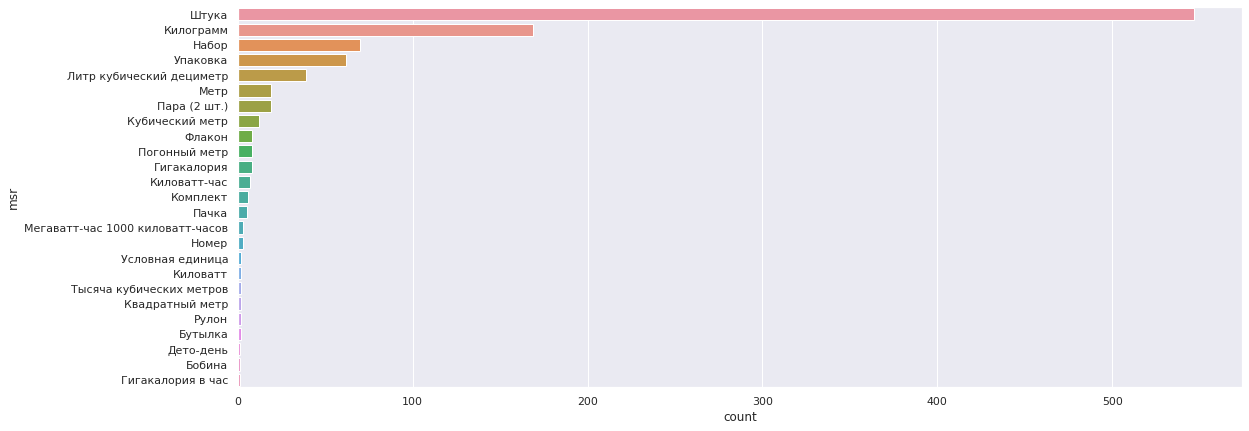

In [ ]:
sns.barplot(x = msr_to_plot['count'], y = msr_to_plot['msr'])

The ratio of medians and means in all product categories (okpd2_name)

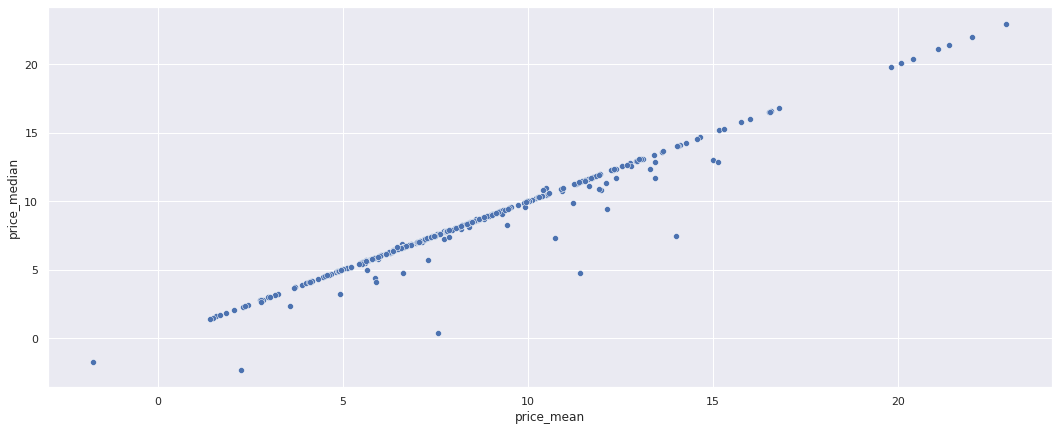

In [ ]:
sns.scatterplot(x=np.log2(prices_name.price_mean), y=np.log2(prices_name.price_median))

Distribution of prices of all goods

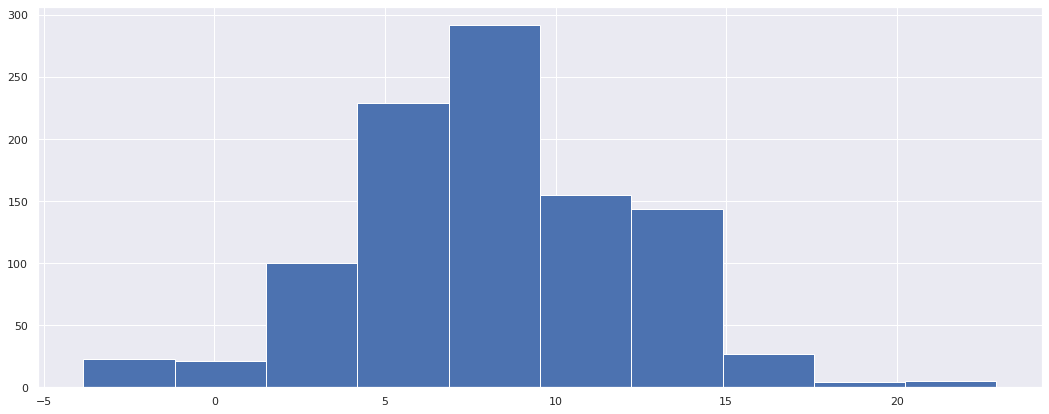

In [ ]:
np.log2(fz_44.price).hist()

Distribution of prices of all goods

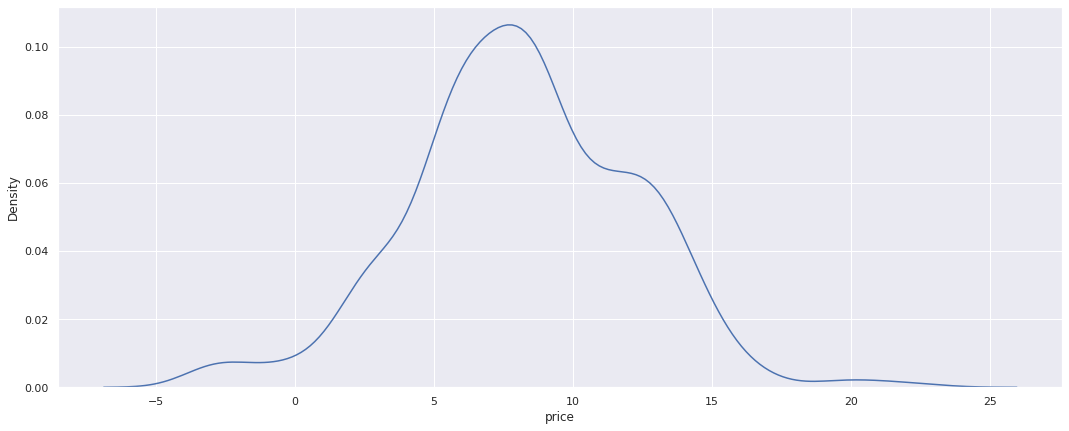

In [ ]:
sns.kdeplot(np.log2(fz_44.price))

Series with prices for the most popular category (small dataset)

In [ ]:
to_plot_reag = fz_44[fz_44.okpd2_name == 'Реагенты диагностические'].price

print(to_plot_reag.mean(), to_plot_reag.median())

9982.063469387755 5138.0


Distribution of prices for the most popular category of goods (Diagnostic reagents)

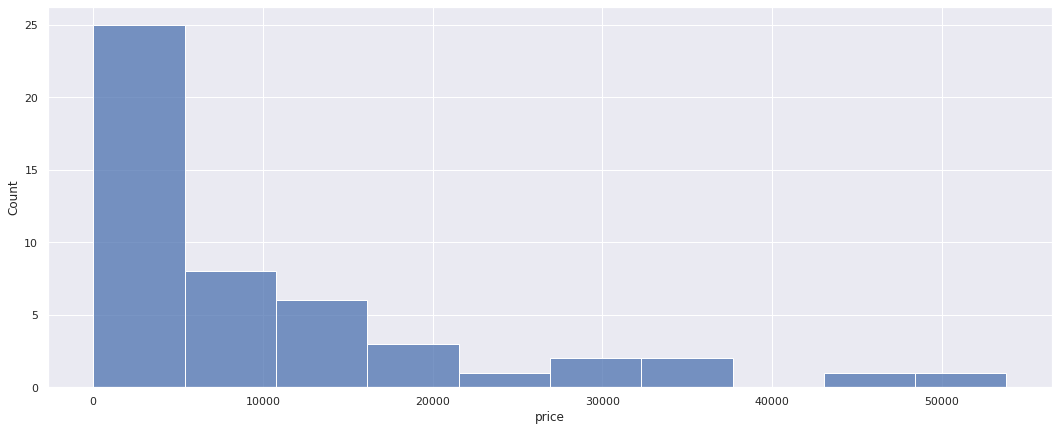

In [ ]:
sns.histplot(to_plot_reag)

In [ ]:
types_prices = fz_44[['okpd2_name', 'price']]
types_prices = types_prices.groupby('okpd2_name').agg({'price': 'sum'}).reset_index()

Distribution of sums of prices in each category (okpd2_name)

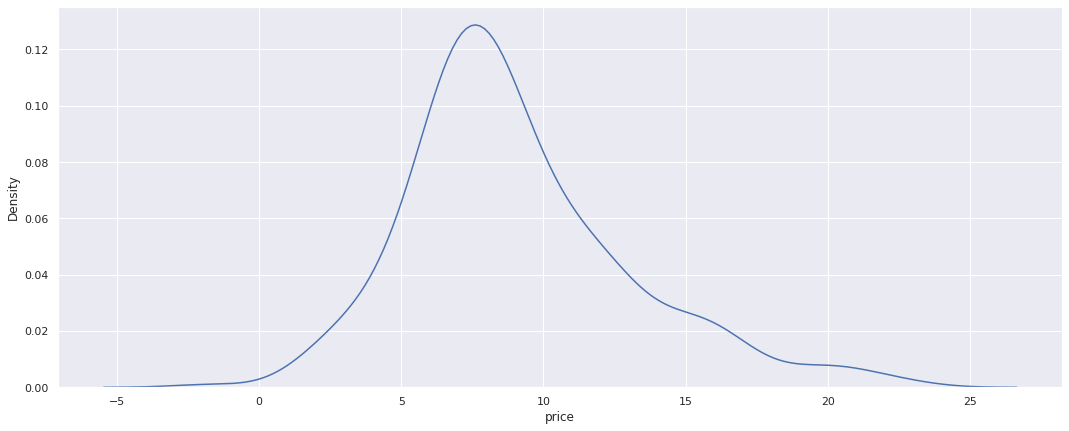

In [ ]:
sns.kdeplot(np.log2(types_prices.price))

Creation of a pivot table with competition indices: product category * country

In [ ]:
new = fz_44_2.groupby(['okpd2_code', 'country_code'], as_index=False).agg({'inn': 'count'})
new['country_code'] = new.country_code.apply(lambda x: str(x).split('|'))
new = new.explode('country_code')
new.drop_duplicates(inplace=True)
new = new.reset_index().drop('index', axis=1)
table = pd.pivot_table(data=new, index='okpd2_code', values='inn', columns='country_code', fill_value=0, aggfunc='sum')
table.reset_index(inplace=True)

Exactly the same pivot table, only there is no okpd2_code column (it stands instead of indexes)

In [ ]:
table_without_okpd = pd.pivot_table(data=new, index='okpd2_code', values='inn', columns='country_code', fill_value=0, aggfunc='sum')

Quantity of goods sold in all countries (for each category)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


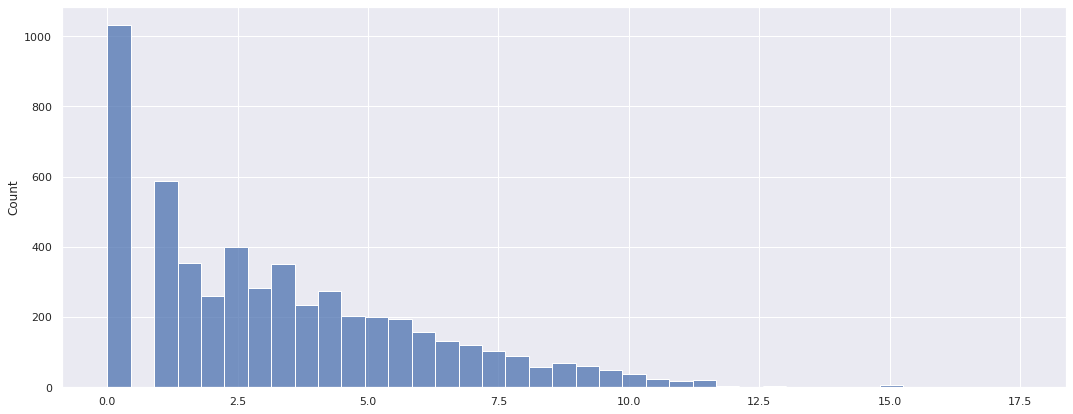

In [ ]:
sns.histplot(np.log2(table.sum(axis=1)))

Creating a table that will display a barplot with the total number of positions in contracts for each country (if there are more than 5000 positions)

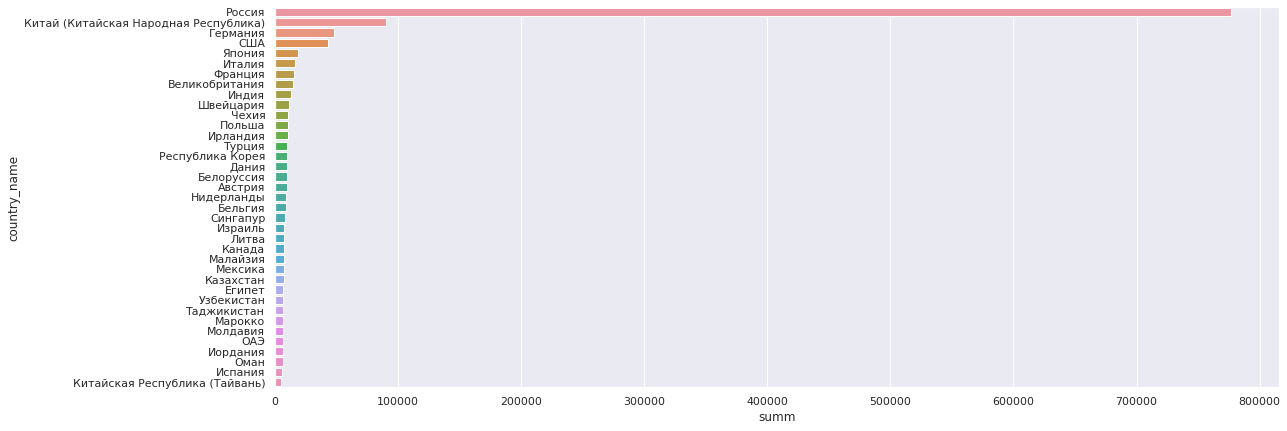

In [ ]:
pivot = pd.DataFrame(table_without_okpd.sum(axis=0))
pivot.reset_index(inplace=True)
pivot['summ'] = pivot[0]
pivot = pivot.drop([0], axis=1)
pivot = pivot.astype({'country_code': 'float64'})
pivot = pivot.merge(country, how='inner', left_on='country_code', right_on='country_iso_code')
pivot = pivot.drop('country_iso_code', axis=1)

pivot = pivot.sort_values('summ', ascending=False)
sns.barplot(x = pivot[pivot['summ'] > 5000].summ, y = pivot[pivot['summ'] > 5000].country_name)

Barplot showing the countries with the most competition in a given product category

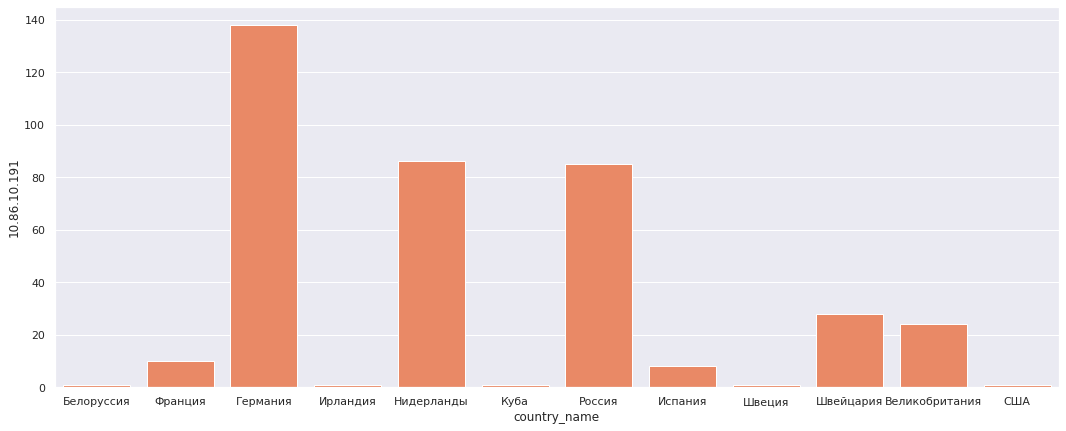

In [ ]:
help = table_without_okpd[table_without_okpd.sum(axis=1) == table_without_okpd.sum(axis=1)].T

category_country = '10.86.10.191'
help = help[help[category_country] > 0].reset_index()

help = help.astype({'country_code': 'float64'}).rename({'10.86.10.191': 'count'})
help = help.merge(country, how='inner', left_on='country_code', right_on='country_iso_code')
sns.barplot(x = help['country_name'], y = help['10.86.10.191'], color='coral')

Hypothesis: each supplier has a priority category for him

Dataframe (index_seller), which should have included the supplier (TIN) and its coefficient in the priority category for it, but the hypothesis was not confirmed

In [ ]:
index_seller = pd.DataFrame(fz_44_2.inn.value_counts()).reset_index()
index_seller.rename(columns={'index': 'inn', 'inn': 'count'}, inplace=True)

In [ ]:
fz_44_2.okpd2_name[fz_44_2['inn'] == '7403de10a7d9337677da1cfdab364bbb'].value_counts().head(1) \
/ fz_44_2.okpd2_name[fz_44_2['inn'] == '7403de10a7d9337677da1cfdab364bbb'].value_counts().sum()

Учебники печатные общеобразовательного назначения    0.93842
Name: okpd2_name, dtype: float64

In [ ]:
fz_44_2.okpd2_name[fz_44_2['inn'] == '2abab90eb911b70e53a05ba7a526e235'].value_counts()

Части и принадлежности для автотранспортных средств прочие, не включенные в другие группировки                              13484
Прочие услуги по техническому обслуживанию и ремонту прочих автотранспортных средств, не включенные в другие группировки     1057
Name: okpd2_name, dtype: int64

Two symmetrical dataframes:

1. seller_top - list of categories (for each supplier) in which the supplier has the most sales

2. okpd_top - list of suppliers (for each category) with the highest number of items sold



In [ ]:
seller_top = fz_44_2[['inn', 'okpd2_code']]
okpd_top = fz_44_2[['inn', 'okpd2_code']]

okpd_top = pd.DataFrame(okpd_top.groupby('okpd2_code')['inn'].agg(pd.Series.mode)).reset_index()
seller_top = pd.DataFrame(seller_top.groupby('inn')['okpd2_code'].agg(pd.Series.mode)).reset_index()

In a specific category, for a specific supplier, we display its place in terms of the number of sales among all suppliers

In [66]:
sellers = fz_44_2[['inn', 'okpd2_code']]

your_inn = '91c23daf46d288344828eac627074bf3'
category = '10.11.31.130'

take = pd.DataFrame(sellers[sellers.okpd2_code == category].inn.value_counts()).reset_index().rename(columns={'index': 'inn', 'inn': 'count'})
take = take.sort_values('count', ascending=False)

take['percent'] = take['count'] / sum(take['count'])
take['Index_norm'] = normalize(take['count'][:,np.newaxis], axis=0).ravel()
idx = take[take.inn == your_inn].index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


In [67]:
print(f'Вы на {idx.to_list()[0] + 1} месте среди всех поставщиков\nВаш индекс конкуренции - {round(take["Index_norm"][idx.to_list()[0]], 3)}')

Вы на 2 месте среди всех поставщиков
Ваш индекс конкуренции - 0.367


Top 10 sallers in category

In [ ]:
take.head(10)

,inn,count,percent,Index_norm
0,3c55068a19e8a40413a629096d252ba0,16,0.089888,0.534522
1,91c23daf46d288344828eac627074bf3,11,0.061798,0.367484
2,b0cf17452baf713e58b3fd22aa5d8cb2,8,0.044944,0.267261
3,a4522af60a24a6ef26bf8f889fd8eb15,7,0.039326,0.233854
4,f2746c2ad0ca2669fe35ea8f86dfe710,7,0.039326,0.233854
5,c6b83b1fc088f9b78da6e7313900e7c2,7,0.039326,0.233854
6,d9fa160c5f2b009186cd8f22150b25f7,6,0.033708,0.200446
7,739ea9c0f966b1e3d606df84329a1ce2,6,0.033708,0.200446
8,ce263c04ed811002cfc87120af9a7ded,5,0.028090,0.167038
12,f0d2d37b4d1b5b7b7c7486d41f72ac28,4,0.022472,0.133631


Distribution of competition indices for all suppliers in a particular category

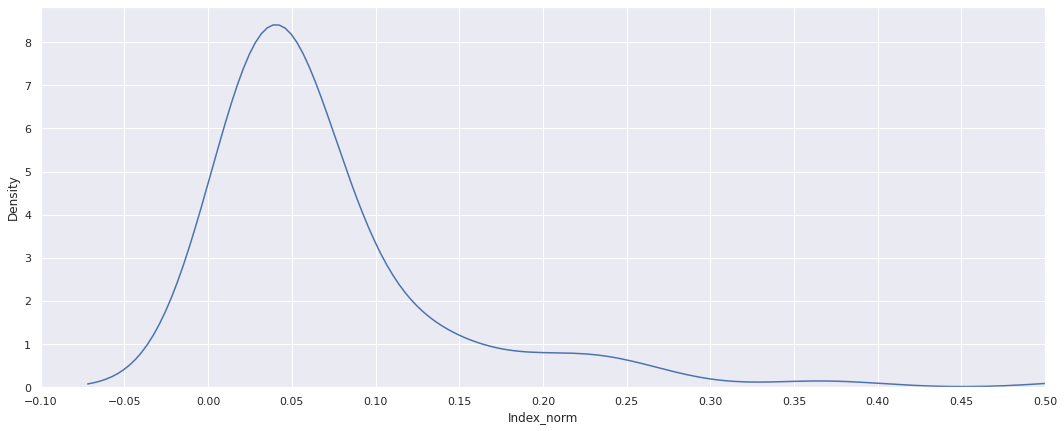

In [ ]:
plt.xticks(np.arange(-0.1, 0.7, 0.05))
plt.xlim(-0.1, 0.5)
sns.kdeplot(take.Index_norm)

Top 3 countries to which the supplier delivers goods when choosing a specific category for it

In [ ]:
result = fz_44_2[fz_44_2.inn == your_inn][['inn', 'okpd2_code', 'country_code']]
result = result[result.okpd2_code == category]

result_df = pd.DataFrame(result.country_code.value_counts()).reset_index()\
                .rename(columns={'index': 'country_code', 'country_code': 'count'})\
                .sort_values('count', ascending=False)

result_df = result_df.astype({'country_code': 'float64'})
result_df = result_df.merge(country, how='inner', left_on='country_code', right_on='country_iso_code')
result_df = result_df.drop('country_iso_code', axis=1)

result_df = result_df.head(3)

result_df

,country_code,count,country_name
0,643.0,11,Россия


Charts for market analysis

In [ ]:
check = fz_44_2[fz_44_2.okpd2_code == category][['price', 'okpd2_code', 'inn']]

Price distribution in a specific category

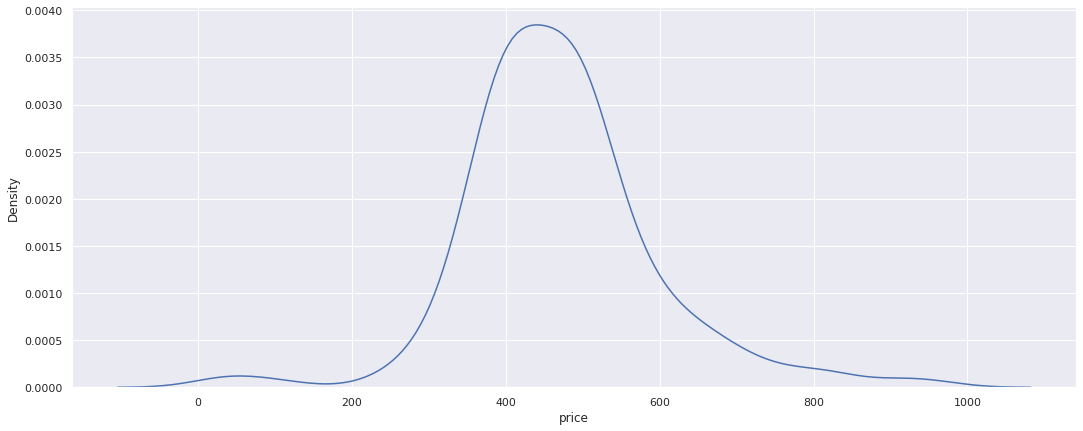

In [ ]:
sns.kdeplot(check['price'])

Plot of distribution of normalized prices for a specific category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


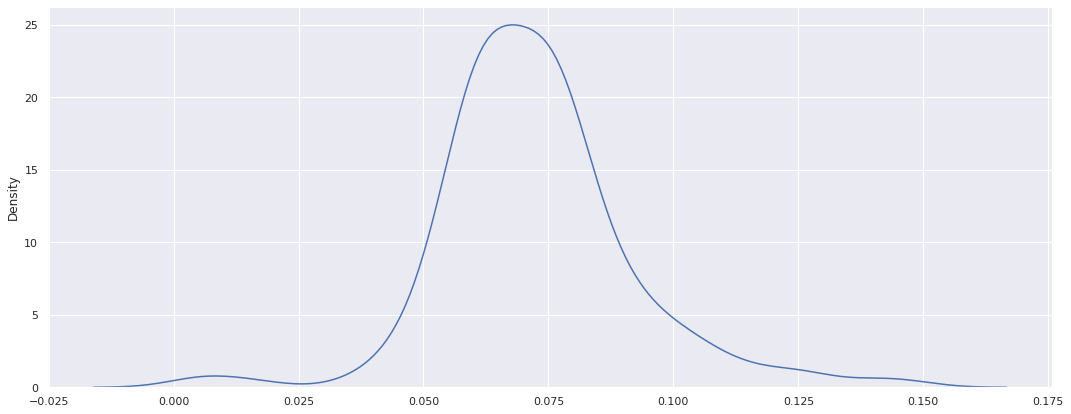

In [ ]:
category_price_df = fz_44_2[['okpd2_code', 'price']]
category_price_df = category_price_df[category_price_df.okpd2_code == category]
sns.kdeplot(normalize(category_price_df['price'][:,np.newaxis], axis=0).ravel())

The number of sales from the first 15 people in this category (checking the market for monopoly)

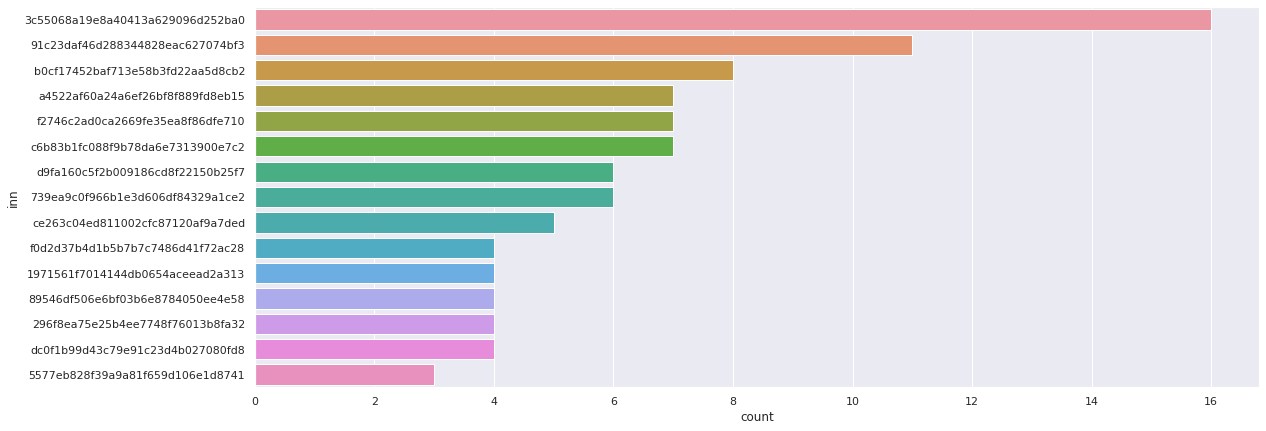

In [ ]:
sns.barplot(y = take['inn'].head(15), x = take['count'].head(15))